<a href="https://colab.research.google.com/github/mosaicthej/astro-obs/blob/master/Gaia_TESS_NEA_WDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs and Functions
#%%capture
!pip install --pre astroquery[all]
from astroquery.gaia import GaiaClass
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
import math
from prettytable import PrettyTable
import numpy
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Catalogs
!python -m pip install lightkurve --upgrade
#import lightkurve as lk
#from lightkurve import search_targetpixelfile
import bokeh.plotting as bk
import matplotlib as mpl
from bokeh.models import Range1d, Label
from bokeh.models import Title
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, output_file, show
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
import requests
import re
bk.output_notebook()
%matplotlib inline

############################################################

def process_row(row, numdec, ra, dec, hmsdms):
  new_row = []
  for val in row:
    if type(val) == numpy.float64 or type(val) == numpy.float32:
      val = float(val)
      val = round(val,numdec)
    else:
      val = "--"
    new_row.append(val)
  new_row.append(ra)
  new_row.append(dec)
  new_row.append(hmsdms)
  return(new_row)

############################################################

def get_TESS_lightcurve_data(tpf_file):
  lc = tpf_file.to_lightcurve(aperture_mask=tpf_file.pipeline_mask)
  rows, ts, fluxes = [], [], []
  row_texts = []
  row_count = 0
  for line in lc:
    time = float(line['time'].value)
    flux = float(line['flux'].value)
    flux_err = float(line['flux_err'].value)
    centroid_col = float(line['centroid_col'].value)
    centroid_row = float(line['centroid_row'].value)
    cadenceno = float(line['cadenceno'])
    quality = float(line['quality'])

    row = [time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality]
    rows.append(row)

    row_text = str(f"{time},{flux},{flux_err},{centroid_col},{centroid_row},{cadenceno},{quality}\n")
    row_texts.append(row_text)

    ts.append(time)
    fluxes.append(flux)
    row_count +=1
  return (rows, row_texts, ts, fluxes, row_count)

#######################################################################


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.2/911.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.9/195.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.2/933.2 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.6/927.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata

In [ ]:
# Make a copy of this Colab.
# Run the first cell.
# Edit the coordinates of your system at the bottom of this cell in the correct format.
# Run this cell to query the 10 closest stars around those coordinates from Gaia DR3.

############################################################

def query_Gaia(coord_string, numstars, numdec):
  x = PrettyTable()
  x.field_names = ["PA", "Sep", "Gmag", "Color", "Plx", "ePlx", "pmra", "epmra", "pmdec", "epmdec", "rv", "erv", "Bmag", "Rmag", "RA", "Dec", "hmsdms"]

  coord = SkyCoord(coord_string)
  GaiaClass.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3
  width = u.Quantity(0.1, u.deg)
  height = u.Quantity(0.1, u.deg)
  gaia = GaiaClass()

  r = gaia.query_object(coordinate=coord, width=width, height=height)

  print(f"The {numstars} closest stars in order of proximity to {coord_string} are:")

  for i in range(0,numstars):
    ra, dec = round(float(r[i]["ra"]),7), round(float(r[i]["dec"]),7)
    c = SkyCoord(ra, dec, unit="deg")
    hmsdms = c.ra.to_string(u.hour) + " " + c.dec.to_string(u.degree, alwayssign=True)
    plx, eplx = r[i]["parallax"], r[i]["parallax_error"]
    distance = 1000/plx
    Gmag = r[i]["phot_g_mean_mag"]
    Bmag = r[i]["phot_bp_mean_mag"]
    Rmag = r[i]["phot_rp_mean_mag"]
    color = Bmag - Rmag
    pmra, epmra, pmdec, epmdec = r[i]["pmra"], r[i]["pmra_error"], r[i]["pmdec"], r[i]["pmdec_error"]
    rv, erv = r[i]["radial_velocity"], r[i]["radial_velocity_error"]
    PA = coord.position_angle(c).degree
    sep = 3600*coord.separation(c).degree
    row = [PA, sep, Gmag, color, plx, eplx, pmra, epmra, pmdec, epmdec, rv, erv, Bmag, Rmag]
    new_row = process_row(row, numdec, ra, dec, hmsdms)
    x.add_row(new_row)

  return(x)

############################################################


coord_string = "04h00m03.83s-29d02m16.5s"
coord_string = "4h00m03.921528s -29d02m16.64304s"

numstars = 10  # Number of nearby stars to show
numdec = 5    # Number of decimal places to show (ra, dec always show 5 decimals)

x = query_Gaia(coord_string, numstars, numdec)
print(x)

The 10 closest stars in order of proximity to 4h00m03.921528s -29d02m16.64304s are:
+-----------+----------+----------+---------+----------+---------+----------+---------+-----------+---------+----------+---------+----------+----------+------------+-------------+----------------------------------+
|     PA    |   Sep    |   Gmag   |  Color  |   Plx    |   ePlx  |   pmra   |  epmra  |   pmdec   |  epmdec |    rv    |   erv   |   Bmag   |   Rmag   |     RA     |     Dec     |              hmsdms              |
+-----------+----------+----------+---------+----------+---------+----------+---------+-----------+---------+----------+---------+----------+----------+------------+-------------+----------------------------------+
|    90.0   |   0.0    | 9.74865  | 1.45378 | 19.77104 | 0.20475 | 84.14116 | 0.19792 | -13.20722 | 0.21404 | 14.21575 | 2.37052 | 10.41215 | 8.95837  | 60.0163397 | -29.0379564 | 4h00m03.921528s -29d02m16.64304s |
| 171.64114 | 11.6306  | 10.00438 | 1.39216 | 20.51221 |

**Ignore cells below: they will become relevant later in the course.**

In [ ]:
!pip install astroquery
!pip install astropy

In [ ]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

coord_string = "06h31m56s-04d58m20.0s" # Rosette

# Define your coordinate and width/height of the search area
coord = SkyCoord(coord_string, frame='icrs')
width = u.Quantity(0.5, u.deg)
height = u.Quantity(0.5, u.deg)

# Define the query with the condition BP-RP < 0
query = f"""
SELECT * FROM gaiaedr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    BOX('ICRS', {coord.ra.deg}, {coord.dec.deg}, {width.to(u.deg).value}, {height.to(u.deg).value})
)
AND (bp_rp < 0)
"""

# Execute the query
job = Gaia.launch_job(query)
r = job.get_results()


# Now, r should contain the results with BP-RP < 0
print(r)

    solution_id              DESIGNATION          ...       ecl_lat      
                                                  ...         deg        
------------------- ----------------------------- ... -------------------
1636042515805110273 Gaia EDR3 3103507672622307712 ...  -28.29535651039647
1636042515805110273 Gaia EDR3 3104256165159817472 ... -28.362838777824887
1636042515805110273 Gaia EDR3 3104257569611579264 ... -28.316172995341457
1636042515805110273 Gaia EDR3 3104258398543745792 ... -28.286974498503145
1636042515805110273 Gaia EDR3 3104259532415196544 ... -28.245642363183133
1636042515805110273 Gaia EDR3 3104260391408585856 ... -28.304123855101693
1636042515805110273 Gaia EDR3 3104261387840165888 ...  -28.28054626907955
1636042515805110273 Gaia EDR3 3104262075035867392 ...  -28.22305164364456
1636042515805110273 Gaia EDR3 3104263827381318528 ...  -28.18776348387643
1636042515805110273 Gaia EDR3 3104264342778598656 ... -28.131892516531575
1636042515805110273 Gaia EDR3 31042824

In [ ]:
############################################################

def query_Gaia(coord_string, numdec):
  x = PrettyTable()
  x.field_names = ["PA", "Sep", "Gmag", "Color", "Plx", "ePlx", "pmra", "epmra", "pmdec", "epmdec", "rv", "erv", "Bmag", "Rmag", "RA", "Dec", "hmsdms"]

  coord = SkyCoord(coord_string)
  GaiaClass.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3
  width = u.Quantity(1.0, u.deg)
  height = u.Quantity(1.0, u.deg)
  gaia = GaiaClass()

  # Define the query with the condition BP-RP < 0
  query = f"""
SELECT * FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    BOX('ICRS', {coord.ra.deg}, {coord.dec.deg}, {width.to(u.deg).value}, {height.to(u.deg).value})
)
AND (bp_rp < 0)
"""

  # Execute the query
  job = Gaia.launch_job(query)
  r = job.get_results()


#  r = gaia.query_object(coordinate=coord, width=width, height=height)

  for i in range(0,len(r)):
    ra, dec = round(float(r[i]["ra"]),7), round(float(r[i]["dec"]),7)
    c = SkyCoord(ra, dec, unit="deg")
    hmsdms = c.ra.to_string(u.hour) + " " + c.dec.to_string(u.degree, alwayssign=True)
    plx, eplx = r[i]["parallax"], r[i]["parallax_error"]
    distance = 1000/plx
    Gmag = r[i]["phot_g_mean_mag"]
    Bmag = r[i]["phot_bp_mean_mag"]
    Rmag = r[i]["phot_rp_mean_mag"]
    color = Bmag - Rmag
    pmra, epmra, pmdec, epmdec = r[i]["pmra"], r[i]["pmra_error"], r[i]["pmdec"], r[i]["pmdec_error"]
    rv, erv = r[i]["radial_velocity"], r[i]["radial_velocity_error"]
    PA = coord.position_angle(c).degree
    sep = 3600*coord.separation(c).degree
    row = [PA, sep, Gmag, color, plx, eplx, pmra, epmra, pmdec, epmdec, rv, erv, Bmag, Rmag]
    new_row = process_row(row, numdec, ra, dec, hmsdms)
    x.add_row(new_row)

  return(x)

############################################################

coord_string = "06h31m56s-04d58m20.0s" # Rosette
numdec = 5    # Number of decimal places to show (ra, dec always show 5 decimals)

x = query_Gaia(coord_string, numdec)
print(x)

The 100 closest stars in order of proximity to 06h31m56s-04d58m20.0s are:
+-----------+------------+----------+----------+----------+---------+-----------+---------+-----------+---------+----+-----+----------+----------+------------+------------+---------------------------------+
|     PA    |    Sep     |   Gmag   |  Color   |   Plx    |   ePlx  |    pmra   |  epmra  |   pmdec   |  epmdec | rv | erv |   Bmag   |   Rmag   |     RA     |    Dec     |              hmsdms             |
+-----------+------------+----------+----------+----------+---------+-----------+---------+-----------+---------+----+-----+----------+----------+------------+------------+---------------------------------+
| 247.31215 | 1918.36148 | 20.99654 | -0.25156 |    --    |    --   |     --    |    --   |     --    |    --   | -- |  -- | 19.56177 | 19.81333 | 97.4896761 | -5.1775728 | 6h29m57.522264s -5d10m39.26208s |
| 230.94556 | 2255.90417 | 20.76959 | -0.08535 |    --    |    --   |     --    |    --   |     --

In [ ]:
query = """SELECT
    source_id, ra, dec, phot_g_mean_mag, parallax, pmra, pmdec, radial_velocity
FROM
    gaiadr3.gaia_source
WHERE
    CONTAINS(POINT('ICRS', ra, dec),
             CIRCLE('ICRS', <RA in decimal degrees>, <DEC in decimal degrees>, <radius in degrees>)) = 1
ORDER BY
    phot_g_mean_mag ASC"""


In [ ]:
def query_Gaia_for_type_O(coord_string, numstars, numdec):
  x = PrettyTable()
  x.field_names = ["PA", "Sep", "Gmag", "Color", "Plx", "ePlx", "pmra", "epmra", "pmdec", "epmdec", "rv", "erv", "Bmag", "Rmag", "RA", "Dec", "hmsdms"]

  coord = SkyCoord(coord_string)
  GaiaClass.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3
  width = u.Quantity(0.1, u.deg)
  height = u.Quantity(0.1, u.deg)

  gaia = GaiaClass()
  gaia.ROW_LIMIT = -1

  query = f"""
SELECT * FROM gaiaedr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    BOX('ICRS', {coord.ra.deg}, {coord.dec.deg}, {width}, {height})
)
AND (bp_rp < 0)
"""

  job = gaia.launch_job(query)
  r = job.get_results()

  r = gaia.query_object(coordinate=coord, width=width, height=height)

  print(f"The {numstars} closest stars in order of proximity to {coord_string} are:")

  for i in range(0,numstars):
    ra, dec = round(float(r[i]["ra"]),7), round(float(r[i]["dec"]),7)
    c = SkyCoord(ra, dec, unit="deg")
    hmsdms = c.ra.to_string(u.hour) + " " + c.dec.to_string(u.degree, alwayssign=True)
    plx, eplx = r[i]["parallax"], r[i]["parallax_error"]
    distance = 1000/plx
    Gmag = r[i]["phot_g_mean_mag"]
    Bmag = r[i]["phot_bp_mean_mag"]
    Rmag = r[i]["phot_rp_mean_mag"]
    color = Bmag - Rmag
    pmra, epmra, pmdec, epmdec = r[i]["pmra"], r[i]["pmra_error"], r[i]["pmdec"], r[i]["pmdec_error"]
    rv, erv = r[i]["radial_velocity"], r[i]["radial_velocity_error"]
    PA = coord.position_angle(c).degree
    sep = 3600*coord.separation(c).degree
    if (Bmag - Rmag > 0):
      continue
    row = [PA, sep, Gmag, color, plx, eplx, pmra, epmra, pmdec, epmdec, rv, erv, Bmag, Rmag]
    new_row = process_row(row, numdec, ra, dec, hmsdms)
    x.add_row(new_row)

  return(x)

############################################################

coord_string = "06h31m56s-04d58m20.0s" # Rosette

numstars = 100  # Number of nearby stars to show
numdec = 5       # Number of decimal places to show (ra, dec always show 5 decimals)

x = query_Gaia_for_type_O(coord_string, numstars, numdec)
print(x)

In [ ]:
STI_2036_primary = SkyCoord(62.6145872, 57.2631203, unit="deg")
STI_2036_secondary = SkyCoord(62.6182954, 57.2645161, unit="deg")
STI_2036_pa = round(STI_2036_primary.position_angle(STI_2036_secondary).degree, 3)
STI_2036_sep = round(float(3600*STI_2036_primary.separation(STI_2036_secondary).degree),3)

print(f"STI_2036 position_angle: {STI_2036_pa}, separation {STI_2036_sep} arcsec")

STI_2036 position_angle: 55.158, separation 8.796 arcsec


In [ ]:
#@title NASA Exoplanet Archive (NEA) query
# NASA Exoplanet Archive (NEA) query (by target name rather than by coordinates)

####################################################

# function get_NEA_fields: Find the most recent publication that reported each desired field

def get_NEA_fields(raw_data, fields):
  NEA_data = {}
  pubdates = raw_data["pl_pubdate"]  # publication date

  for i in range(len(pubdates)):
    pubdate = pubdates[i]
    NEA_data[pubdate] = {}
    for field in fields:
      NEA_data[pubdate][field] = raw_data[field][i].to_value()

  best_NEA_data = {"pl_pubdate": sorted(pubdates, reverse=True)[0] }

  for field in fields:
    for pubdate in sorted(pubdates, reverse=True):
      datum = NEA_data[pubdate][field]
      if not np.isnan(datum):
        best_NEA_data[field] = float(datum)
        break
    if np.isnan(datum):
      if field == "pl_trandep":
        best_NEA_data["pl_trandep"] = 1.0
  return(best_NEA_data)

####################################################

def get_LCO_request_info(f, best_NEA_data, num_transits, wiggle_room, readout_time, baseline):
  nt = Time.now()
  midt = best_NEA_data["pl_tranmid"]
  p = best_NEA_data["pl_orbper"]
  trandur = best_NEA_data["pl_trandur"]
  vmag = best_NEA_data["sy_vmag"]
#  print(f"midt {midt} {type(midt)} p {p} {type(p)} trandur {trandur} {type(trandur)} vmag {vmag} {type(vmag)} baseline {baseline} {type(baseline)} wiggle_room {wiggle_room} {type(wiggle_room)}")

  window = round((trandur + baseline + wiggle_room),2)
  exposure_time = int(round((60*((2.512)**(vmag-12.5))),0))
  num_exp = int(round(((trandur+baseline)*3600/(exposure_time + readout_time)),0))
  image_details = str(f"Window: {window} hours\nExposure time (LCO 0.4m): {exposure_time} seconds\nRequest: {num_exp} exposures\n")

  upcoming_transits = ""
  epoch = math.ceil(((nt.jd - midt)/p))
  for i in range(num_transits):
    next_transit_jd = midt + p*(epoch+i)
    mid = Time(next_transit_jd, format='jd')
    start = Time((next_transit_jd - (window/(2*24))), format='jd')
    end = Time((next_transit_jd + (window/(2*24))), format='jd')
    start_hr = float(start.isot[11] + start.isot[12])
    end_hr = float(end.isot[11] + end.isot[12])
    if (start_hr >= 0 and start_hr < 10) and (end_hr >= 0 and end_hr < 10):   # Current dark time in Chile (Jan 2023)
      upcoming_transits = upcoming_transits + "**"
    upcoming_transits = upcoming_transits+str(f"{i+1} UTC: {start.isot} - {mid.isot} - {end.isot}\n")
  return(image_details+upcoming_transits)

####################################################

def get_info(target, f, num_transits, wiggle_room, readout_time, baseline):
  fields = f.keys()
  raw_data = NasaExoplanetArchive.query_object(target)
  best_NEA_data = get_NEA_fields(raw_data, fields)
  target_info = str(f"Target {target}\n")
  for field in fields:
    v = best_NEA_data[field]
    target_info = target_info + str(f"{f[field]['name']}: {v} {f[field]['unit']}\n")
  image_request_info = get_LCO_request_info(f, best_NEA_data, num_transits, wiggle_room, readout_time, baseline)
  return(target_info+image_request_info)

####################################################

f = {"ra": {"name": "ra", "unit": "deg"}, "dec": {"name": "dec", "unit": "deg"}, "pl_tranmid": {"name": "transit midpoint", "unit": "BJD"}, "pl_orbper": {"name": "orbital period", "unit": "days"}, "pl_trandur": {"name": "transit duration", "unit": "hours"}, "pl_trandep": {"name": "transit depth", "unit": "percent"}, "sy_bmag": {"name": "Bmag", "unit":""}, "sy_vmag": {"name": "Vmag", "unit": ""}}
num_transits = 50
wiggle_room = 0.35  # flexibility for the LCO scheduler (increases probability images will be taken)
readout_time = 14   # seconds of readout time per exposure for the LCO cameras
baseline = 2        # request 2 hours of baseline images: one hour on either side of the midtransit

targets = ["HATS-72 b", "WASP-45 b", "WASP-18 b", "HIP 65 A b", "WASP-4 b"]
targets = ["WASP-33 b", "WASP-76 b", "Qatar-7 b", "K2-29 b", "HIP 65 A b", "HAT-P-68 b", "HAT-P-70 b"]
targets = ["HIP 65 A b"]

for target in targets:
  info = get_info(target, f, num_transits, wiggle_room, readout_time, baseline)
  print(f"{info}\n")


Filename: /root/.astropy/cache/download/url/2d0c9a253abcda71c3b3625c32c61df7/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   20076R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


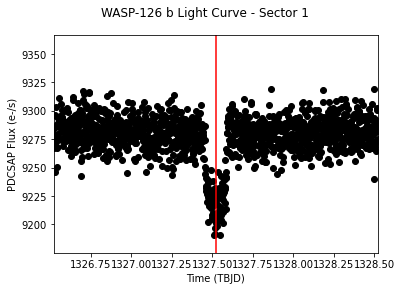

In [ ]:
fits_file = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0000/2515/5310/tess2018206045859-s0001-0000000025155310-0120-s_lc.fits"
fits.info(fits_file)
fits.getdata(fits_file, ext=1).columns
with fits.open(fits_file, mode="readonly") as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
# Define the epoch of primary transit in TBJD.  Our timestamps are also already in TBJD.
t0 = 1327.520678

# Start figure and axis.
fig, ax = plt.subplots()

# Plot the timeseries in black circles.
ax.plot(tess_bjds, pdcsap_fluxes, 'ko')

# Center the x-axis on where we expect a transit to be (time = T0), and set
# the x-axis range within +/- 1 day of T0.
ax.set_xlim(t0 - 1.0, t0 + 1.0)

# Overplot a red vertical line that should be where the transit occurs.
ax.axvline(x=t0, color="red")

# Let's label the axes and define a title for the figure.
fig.suptitle("WASP-126 b Light Curve - Sector 1")
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (TBJD)")

# Adjust the left margin so the y-axis label shows up.
plt.subplots_adjust(left=0.15)
plt.show()

In [ ]:
# Scrape WDS by pulling down one of four Very Large Text Files
coord = "00h00m09.71s-25d19m29.3s"
coord = "20h24m29.74s+16d45m43.73s"
c = SkyCoord(coord)

wds_url = "http://www.astro.gsu.edu/wds/Webtextfiles/wdsnewerweb"
url = ""
if c.ra.deg < 90:
  url = wds_url + "1.txt"
elif c.ra.deg < 180:
  url = wds_url + "2.txt"
elif c.ra.deg < 240:
  url = wds_url + "3.txt"
else:
  url = wds_url + "4.txt"

data = requests.get(url,verify = False)
lines = data.text.splitlines()

In [ ]:
# Find the known double stars in the field of the target.

for i in range(1,5):  # prints the header of the WDS file.
    print(lines[i])

for i in range(len(lines)):
  l = lines[i]
  m = re.search("^(\d\d\d\d\d[+-]\d\d\d\d)([\w\s][\w\s][\w\s][\w\s][\w\s][\w\s][\w\s]).+?(\d\d)(\d\d)(\d\d\.\d+)([+-]\d\d)(\d\d)(\d\d\.\d+)$", l)
  if m:
    num, disc = m.group(1), m.group(2)
    c1 = SkyCoord(m.group(3)+"h"+m.group(4)+"m"+m.group(5)+"s"+m.group(6)+"d"+m.group(7)+"m"+m.group(8)+"s")
    sep = 240*c.separation(c1).degree
    if sep < 200:
      print(l)

In [ ]:
!python -m pip install lightkurve --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install lightkurve.io
import lightkurve as lk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement lightkurve.io (from versions: none)
ERROR: No matching distribution found for lightkurve.io


TypeError: ignored

In [ ]:
# TESS query (by target name rather than by coordinates)
# Sample targets: TIC 084306468 (CH Cam in NGC 1501), HIP 65 A b, HAT-P-23 b, HD 189733 B

target = "WASP-33 b"
search_result = lightkurve.search_targetpixelfile(target)
pixelfile = search_targetpixelfile(target).download_all();

filenum = 0
tpf_file = search_result[filenum].download(quality_bitmask='default')
(rows, row_texts, ts, fluxes, row_count) = get_TESS_lightcurve_data(tpf_file)
print(search_result)
print(f"There are {row_count} rows in the first TESS file.")
#print(pixelfile)
#pixelfile.plot()

p = figure(width=800, height=300)
p.scatter(ts, fluxes)
bk.show(p)

NameError: ignored